In [1]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = {
        "HINS1": 'HINS1_2.0',
        "HINS2": 'HINS2_2.0',
        "HINS4": 'HINS4_2.0',
        "CIT": 'CIT_1.0',
        "COW" : 'COW_1.0',
        "SCHL" : 'SCHL_16.0',
        "MAR": 'MAR_5.0',
        "SEX": 'SEX_1.0',
        "RAC1P" :'RAC1P_1.0',
        "ENG" : 'ENG_1.0',
        }
    drop_cols = []
    for i in cols:
        if cols[i] == '':
            drop_first = f'{i}_{df_processed[i].value_counts().idxmax()}'
            cols[i] = drop_first
        else:
            drop_first = cols[i]
        drop_cols.append(drop_first)
        df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=[i]) ; df_processed.drop(columns=drop_first, inplace=True)
    return df_processed, df, target, sex, cols

data, data_original, target, group, cols = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

In [2]:
cols
# The details of our "example" person

{'HINS1': 'HINS1_2.0',
 'HINS2': 'HINS2_2.0',
 'HINS4': 'HINS4_2.0',
 'CIT': 'CIT_1.0',
 'COW': 'COW_1.0',
 'SCHL': 'SCHL_16.0',
 'MAR': 'MAR_5.0',
 'SEX': 'SEX_1.0',
 'RAC1P': 'RAC1P_1.0',
 'ENG': 'ENG_1.0'}

### Reference Person Explanation
When encoding the discrete variables of our data. We chose the reference datapoint from Table: XX.
We chose to use this reference person as we assert this person is the "generic" american citizen in this case. <br>
| **Variable** | **Value** | **Reason** |
| --------- | -------- | --------- |
| HINS1 | 2 | As a rule, we assume that respondants don't have any form of insurance. |
| HINS2 | 2 | Same as above. |
| HINS4 | 2 | Same as above. | 
| CIT | 1 | We assume that respondants would be american-born. |
| COW | 1 | We find that working for a private for-profit company is the most "baseline" occupation. |
| SCHL | 16 | We set the reference as High school, since it fits nicely in the middle of the variable. | 
| MAR | 5 | Non-married as reference. Able to compare with the starting point in ones love life. |
| SEX | 1 | Male as reference. Slight majority in data. |
| ENG | 1 | Use very well english speaking as reference, since the country is english speaking natively.|


The overall though process for choosing the reference variables was to choose the variables which best capture the picture of the "ideal average" citizen in the dataset. <br>
We use min-max scaling on the "AGEP" variable, to ensure that our logistic regression model converges within a reasonable time-frame. <br>
In terms of model parameters we copied the Logistic regression parameters from exercise 2 and found that they work quite well for this project. The Random Forest is in initialized with 100 estimators and a max depth of 10. With these parameters we strike a balance between a lightweight tree model and still having the model be complex enough that it stays black-box. <br>


In [3]:
# Using Random Forest to Classify if target is above income threshold

# Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test, threshold1, threshold2):
    global s1, s2, preds_s1, preds_s2, true_s1, true_s2, fpr1, tpr1, thresholds1, fpr2, tpr2, thresholds2, scores_s1, scores_s2   
    pipeline.fit(X_train, y_train)
    # y_pred = pipeline.predict(X_test)
    # Modify pipeline to fulfill one of the fairness criteria (e.g. statistical parity, equal opportunity, etc.)
    X_test = X_test.reset_index(drop=True)
    s2 = X_test.loc[X_test['SEX_2.0'] == True] 
    s1 = X_test.loc[X_test['SEX_2.0'] == False]

    true_s1 = []
    for i in s1.index:
        true_s1.append(y_test[i])
    true_s2 = []
    for i in s2.index:
        true_s2.append(y_test[i])


    scores_s1 = pipeline.predict_proba(s1)[:, 1]
    fpr1, tpr1, thresholds1 = roc_curve(true_s1, scores_s1, pos_label=1)
    scores_s2 = pipeline.predict_proba(s2)[:, 1]
    fpr2, tpr2, thresholds2 = roc_curve(true_s2, scores_s2, pos_label=1)


    preds_s1 = scores_s1 > threshold1
    preds_s2 = scores_s2 > threshold2
    return pipeline

In [102]:
def minimize_odd_diff(scores_1, scores_2, k):
    x = np.linspace(0, 1, k)
    fpr_diff = []
    tpr_diff = []
    for i in x:
        preds_s1 = scores_1 >= i
        preds_s2 = scores_2 >= i
        tn1, fp1, fn1, tp1 = confusion_matrix(preds_s1, true_s1).ravel()
        tn2, fp2, fn2, tp2 = confusion_matrix(preds_s2, true_s2).ravel()
        fpr1 = fp1 / (fp1 + tn1)
        tpr1 = tp1 / (tp1 + fn1)
        fpr2 = fp2 / (fp2 + tn2)
        tpr2 = tp2 / (tp2 + fn2)
        fpr_diff.append(abs(fpr1 - fpr2))
        tpr_diff.append(abs(tpr1 - tpr2))
    return fpr_diff, tpr_diff, x

In [5]:
# Needed to make sure logisric regression converges
X_train['AGEP'] = MinMaxScaler().fit_transform(X_train[['AGEP']])
X_test['AGEP'] = MinMaxScaler().fit_transform(X_test[['AGEP']])

In [6]:
rf_args = {
    'n_estimators': 100, # changed from 100
    'max_depth' : 10, #changed from 10
    'min_samples_split': 2, #changed from 2
    'min_samples_leaf': 2, #changed from 2
    'random_state': 0
}
lr_model = LogisticRegression(max_iter=5000, penalty= "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga", random_state=0)
p1 = RandomForestClassifier(**rf_args)
p2 = lr_model

In [26]:
((1 > 2) and (2 > 1))

False

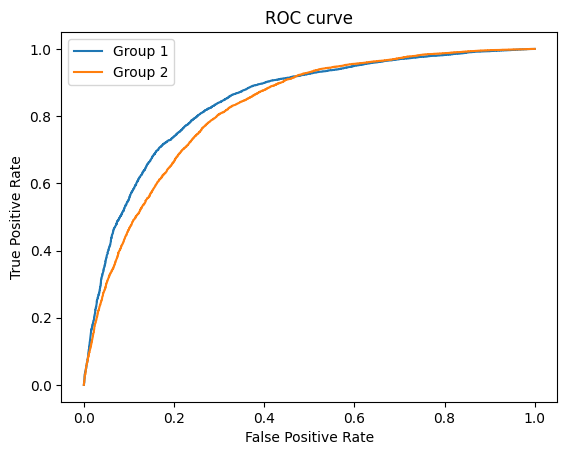

------------BEFORE BIAS ANALYSIS------------
Statistical parity:  0.12479440500799355
FPR diff:  0.02113310851192332
TPR Diff 0.07412778572443823
positive outcome: 0.07887169606031408
negative outcome: 0.044786881289722635
------------AFTER BIAS ANALYSIS------------
Statistical parity:  0.06511966418085768
FPR diff:  0.1492591375515039
TPR Diff 0.15292544105419903
positive outcome diff: 0.10584996423635706
negative outcome diff: 0.15063361803725295


In [82]:
p2_done = evaluate_pipeline(p2, X_train, y_train, X_test, y_test, 0.5, 0.5)
plt.plot(fpr1, tpr1, label='Group 1')
plt.plot(fpr2, tpr2, label='Group 2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('------------BEFORE BIAS ANALYSIS------------')

statistical_parity = np.sum(preds_s1)/len(s1) - np.sum(preds_s2)/len(s2)
print('Statistical parity: ', abs(statistical_parity))

tn1, fp1, fn1, tp1 = confusion_matrix(preds_s1, true_s1).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(preds_s2, true_s2).ravel()

# Calculate Youden's J statistic for each model
youden_j1 = tpr1 - fpr1
optimal_threshold_index1 = np.argmax(youden_j1)
optimal_threshold1 = thresholds1[optimal_threshold_index1]

youden_j2 = tpr2 - fpr2
optimal_threshold_index2 = np.argmax(youden_j2)
optimal_threshold2 = thresholds2[optimal_threshold_index2]

preds_s1 = scores_s1 >= 0.66 # 0.66 best 
preds_s2 = scores_s2 >= 0.43 # 0.4756088801681863 best

# equalized odds (horizontal)
tpr1 = tp1 / (tp1 + fn1)
fpr1 = fp1 / (fp1 + tn1)
tpr2 = tp2 / (tp2 + fn2)
fpr2 = fp2 / (fp2 + tn2)

print('FPR diff: ', abs(fpr1 - fpr2))
print('TPR Diff', abs(tpr1 - tpr2))

# equalized outcomes, given selection, groups have equal outcomes
some_1 = tp1 / (tp1 + fp1)
some_2 = tp2 / (tp2 + fp2)
some_3 = tn1 / (tn1 + fn1)
some_4 = tn2 / (tn2 + fn2)

print('positive outcome:', abs(some_1 - some_2))
print('negative outcome:', abs(some_3 - some_4))


print('------------AFTER BIAS ANALYSIS------------')

statistical_parity = np.sum(preds_s1)/len(s1) - np.sum(preds_s2)/len(s2)
print('Statistical parity: ', abs(statistical_parity))

tn1, fp1, fn1, tp1 = confusion_matrix(preds_s1, true_s1).ravel()
fpr_group1 = fp1 / (fp1 + tn1)
tpr_group1 = tp1 / (tp1 + fn1)

tn2, fp2, fn2, tp2 = confusion_matrix(preds_s2, true_s2).ravel()
fpr_group2 = fp2 / (fp2 + tn2)
tpr_group2 = tp2 / (tp2 + fn2)

# equalized odds (horizontal)
print('FPR diff: ', abs(fpr_group1 - fpr_group2))
print('TPR Diff', abs(tpr_group1 - tpr_group2))

# equalized outcomes, given selection, groups have equal outcomes
some_1 = tp1 / (tp1 + fp1)
some_2 = tp2 / (tp2 + fp2)
some_3 = tn1 / (tn1 + fn1)
some_4 = tn2 / (tn2 + fn2)

print('positive outcome diff:', abs(some_1 - some_2))
print('negative outcome diff:', abs(some_3 - some_4))

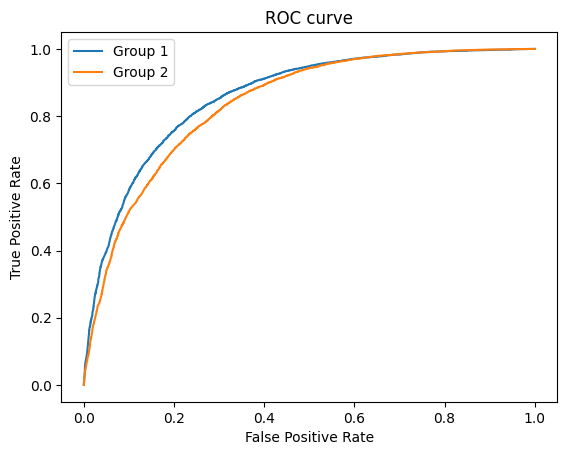

------------BEFORE BIAS ANALYSIS------------
Statistical parity:  0.05506441007159846


/var/folders/7n/1v9m4ykn66ddbcxt5nwgg9280000gn/T/ipykernel_9885/2222849069.py:38: RuntimeWarning: invalid value encountered in scalar divide
  fpr1 = fp1 / (fp1 + tn1)
/var/folders/7n/1v9m4ykn66ddbcxt5nwgg9280000gn/T/ipykernel_9885/2222849069.py:40: RuntimeWarning: invalid value encountered in scalar divide
  fpr2 = fp2 / (fp2 + tn2)
/var/folders/7n/1v9m4ykn66ddbcxt5nwgg9280000gn/T/ipykernel_9885/2222849069.py:38: RuntimeWarning: invalid value encountered in scalar divide
  fpr1 = fp1 / (fp1 + tn1)
/var/folders/7n/1v9m4ykn66ddbcxt5nwgg9280000gn/T/ipykernel_9885/2222849069.py:40: RuntimeWarning: invalid value encountered in scalar divide
  fpr2 = fp2 / (fp2 + tn2)
/var/folders/7n/1v9m4ykn66ddbcxt5nwgg9280000gn/T/ipykernel_9885/2222849069.py:38: RuntimeWarning: invalid value encountered in scalar divide
  fpr1 = fp1 / (fp1 + tn1)
/var/folders/7n/1v9m4ykn66ddbcxt5nwgg9280000gn/T/ipykernel_9885/2222849069.py:40: RuntimeWarning: invalid value encountered in scalar divide
  fpr2 = fp2 / (fp2

FPR diff:  0.058105603320057986
TPR Diff 0.10384135210464918
positive outcome: 0.008409985274989928
negative outcome: 0.02584716571468193
------------AFTER BIAS ANALYSIS------------
Statistical parity:  0.1540417943133635
FPR diff:  0.04037744333008769
TPR Diff 0.04561956148130697
positive outcome diff: 0.15391183486537902
negative outcome diff: 0.03638284897217958


/var/folders/7n/1v9m4ykn66ddbcxt5nwgg9280000gn/T/ipykernel_9885/2222849069.py:41: RuntimeWarning: invalid value encountered in scalar divide
  tpr2 = tp2 / (tp2 + fn2)
/var/folders/7n/1v9m4ykn66ddbcxt5nwgg9280000gn/T/ipykernel_9885/2222849069.py:41: RuntimeWarning: invalid value encountered in scalar divide
  tpr2 = tp2 / (tp2 + fn2)
/var/folders/7n/1v9m4ykn66ddbcxt5nwgg9280000gn/T/ipykernel_9885/2222849069.py:41: RuntimeWarning: invalid value encountered in scalar divide
  tpr2 = tp2 / (tp2 + fn2)
/var/folders/7n/1v9m4ykn66ddbcxt5nwgg9280000gn/T/ipykernel_9885/2222849069.py:39: RuntimeWarning: invalid value encountered in scalar divide
  tpr1 = tp1 / (tp1 + fn1)
/var/folders/7n/1v9m4ykn66ddbcxt5nwgg9280000gn/T/ipykernel_9885/2222849069.py:41: RuntimeWarning: invalid value encountered in scalar divide
  tpr2 = tp2 / (tp2 + fn2)
/var/folders/7n/1v9m4ykn66ddbcxt5nwgg9280000gn/T/ipykernel_9885/2222849069.py:39: RuntimeWarning: invalid value encountered in scalar divide
  tpr1 = tp1 / (tp1

In [97]:
p1_done = evaluate_pipeline(p1, X_train, y_train, X_test, y_test, 0.5, 0.5)

plt.plot(fpr1, tpr1, label='Group 1')
plt.plot(fpr2, tpr2, label='Group 2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('------------BEFORE BIAS ANALYSIS------------')

statistical_parity = np.sum(preds_s1)/len(s1) - np.sum(preds_s2)/len(s2)
print('Statistical parity: ', (statistical_parity))

tn1, fp1, fn1, tp1 = confusion_matrix(preds_s1, true_s1).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(preds_s2, true_s2).ravel()

# Calculate Youden's J statistic for each model
youden_j1 = tpr1 - fpr1
optimal_threshold_index1 = np.argmax(youden_j1)
optimal_threshold1 = thresholds1[optimal_threshold_index1]

youden_j2 = tpr2 - fpr2
optimal_threshold_index2 = np.argmax(youden_j2)
optimal_threshold2 = thresholds2[optimal_threshold_index2]


balls1, balls2, x = minimize_odd_diff(scores_s1, scores_s2, 100)

preds_s1 = scores_s1 >= 0.7  
preds_s2 = scores_s2 >= 0.7 

# equalized odds (horizontal)
tpr1 = tp1 / (tp1 + fn1)
fpr1 = fp1 / (fp1 + tn1)
tpr2 = tp2 / (tp2 + fn2)
fpr2 = fp2 / (fp2 + tn2)

print('FPR diff: ', abs(fpr1 - fpr2))
print('TPR Diff', abs(tpr1 - tpr2))

# equalized outcomes, given selection, groups have equal outcomes
some_1 = tp1 / (tp1 + fp1)
some_2 = tp2 / (tp2 + fp2)
some_3 = tn1 / (tn1 + fn1)
some_4 = tn2 / (tn2 + fn2)

print('positive outcome:', abs(some_1 - some_2))
print('negative outcome:', abs(some_3 - some_4))


print('------------AFTER BIAS ANALYSIS------------')

statistical_parity = np.sum(preds_s1)/len(s1) - np.sum(preds_s2)/len(s2)
print('Statistical parity: ', (statistical_parity))

tn1, fp1, fn1, tp1 = confusion_matrix(preds_s1, true_s1).ravel()
fpr_group1 = fp1 / (fp1 + tn1)
tpr_group1 = tp1 / (tp1 + fn1)

tn2, fp2, fn2, tp2 = confusion_matrix(preds_s2, true_s2).ravel()
fpr_group2 = fp2 / (fp2 + tn2)
tpr_group2 = tp2 / (tp2 + fn2)

# equalized odds (horizontal)
print('FPR diff: ', abs(fpr_group1 - fpr_group2))
print('TPR Diff', abs(tpr_group1 - tpr_group2))

# equalized outcomes, given selection, groups have equal outcomes
some_1 = tp1 / (tp1 + fp1)
some_2 = tp2 / (tp2 + fp2)
some_3 = tn1 / (tn1 + fn1)
some_4 = tn2 / (tn2 + fn2)

print('positive outcome diff:', abs(some_1 - some_2))
print('negative outcome diff:', abs(some_3 - some_4))

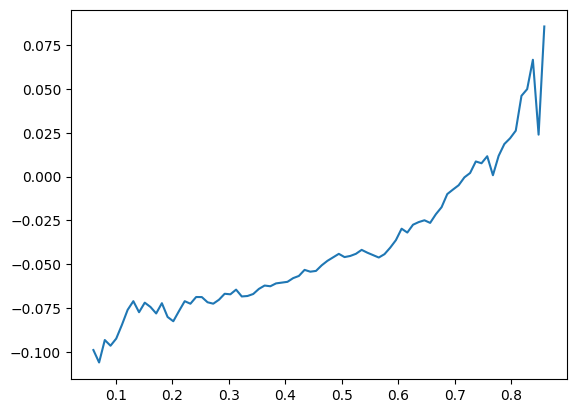

In [101]:
balls3 = (np.array(balls1) - np.array(balls2))
plt.plot(x, balls3)

### Changes to be made to models
The accuracy of the classifier sits at 0.77 as of baseline test with the selected pipeline. Standard-scaling was used across all features, which may end up causing trouble. The model has a fairly high accuracy for a baseline classifier, with desirable f1-scores at [0.72, 0.81]. Since the outcome variable in this case is almost equally balanced at the chosen threshold, we need not to scale our model much with respect to the outcome variable. In this pipeline discrete variables are scaled, which changes the otherwise explainable binary variables, which hurts the explainability of the model. <br>
<br>
We would need to only scale the age column in the data to fix this explainability issue. Unless we had more continuous ways of representing the discrete variables in the data (such as language test scores for english proficiency, SAT scores for education etc.) we would not be able to quantify these columns in any meaningful fashion.

### What we did
In trying to improve the interpretability of our model, we limit the scaling to exclusively be applied to the "AGEP" column, seeing as it is the only continuous variable in the data. We also use the template's onehot-encodings applied to the discrete variables, with dropping the first value applied. This way we can compare each categorical variable to the baseline of the one which is dropped. <br>

Before making any changes to any of the models we find the following accuracies of the classifiers: 
<br>
(insert classification report for models)
<br>



### Scores affected by Equalized outcome
In fine-tuning the thresholds for our models to obtain statistical parity, we found that we had to sacrifice model accuracy on Group 1 (Males), to equalize the outcome accuracy. This meant we had to choose a suboptimal threshold for Group 1 and chose the best Threshold for Group 2. When applying this to the logistic regression model, we found that changing the thresholds obtained equalized outcomes within ~1 percent difference, this threshold change also moved the model closer to obtaining equalized odds, with only a ~2 percent difference. <br>
<br>
When applying this method to the Blackbox Random Forest. 